In [30]:
import json
import matplotlib.pyplot as plt
import pandas as pd

In [31]:
df_all = pd.read_json('./pytorch-train-throughput-fp32.json').set_index('name_gpu')
df_all

,num_gpu,watt,price,ssd,bert_base_squad,bert_large_squad,gnmt,maskrcnn,resnet50,tacotron2,transformerxlbase,transformerxllarge,waveglow
name_gpu,,,,,,,,,,,,,
V100 32GB,1,250,11357,136,42,12,22743,10,368,17604,6518,2329,48458
Quadro RTX 8000,1,260,6900,116,38,11,21808,10,300,10016,6124,2158,45876
Quadro RTX 6000,1,260,4964,118,38,10,21014,10,301,8954,5684,1816,38687
Quadro RTX 5000,1,230,2392,83,26,6,14320,7,213,6841,3188,1034,25736
Titan RTX,1,280,3500,119,39,11,21329,10,306,8732,5801,1878,40381
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4x RTX A4500,4,800,7712,393,206,37,108391,43,1335,52420,34321,6473,215790
8x RTX A4500,8,1600,15424,791,374,64,194500,84,2672,104627,69384,19602,412512
2x RTX A5500,2,460,9000,242,146,33,76639,28,828,38915,23051,8089,150217


In [32]:
df_all.index.unique()

Index(['V100 32GB', 'Quadro RTX 8000', 'Quadro RTX 6000', 'Quadro RTX 5000',
       'Titan RTX', 'RTX 2080Ti', 'GTX 1080Ti', 'RTX 2080 SUPER MAX-Q',
       'RTX 2080 MAX-Q', 'RTX 2070 MAX-Q', 'RTX 3070', 'RTX 3080', 'RTX 3090',
       'A100 40GB PCIe', 'A100 80GB PCIe', 'A100 40GB SXM4', 'A100 80GB SXM4',
       'RTX A6000', 'RTX A5000', 'Lambda Cloud — RTX A6000', 'RTX 3080 Max-Q',
       'RTX A40', 'RTX A4000', 'RTX A4500', 'RTX A5500',
       '2x RTX 2080Ti NVLink', '2x RTX 2080Ti', '4x RTX 2080Ti NVLink',
       '4x RTX 2080Ti', '8x RTX 2080Ti NVLink', '8x RTX 2080Ti',
       '2x RTX Quadro 8000 NVLink', '2x RTX Quadro 8000',
       '4x RTX Quadro 8000 NVLink', '4x RTX Quadro 8000',
       '8x RTX Quadro 8000 NVLink', '8x RTX Quadro 8000', '2x V100 32GB',
       '4x V100 32GB', '8x V100 32GB', 'p3.16xlarge', 'p3.8xlarge',
       'Lambda Cloud — 8x V100 16GB', 'Lambda Cloud — 4x GTX 1080Ti',
       'Lambda Cloud — 2x Quadro RTX 6000',
       'Lambda Cloud — 4x Quadro RTX 6000',
    

In [42]:
def benchmark_df(df: pd.DataFrame, hourly_cost: pd.Series, speedup_base: str) -> pd.DataFrame:
    hourly_cost.name = 'hourly_cost'
    df = df.join(hourly_cost).dropna()

    tf_benchmarks = ['bert_base_squad', 'bert_large_squad', 'transformerxllarge', 'transformerxlbase']
    df['tf_mean'] = df[tf_benchmarks].mean(axis=1)
    df['tf_speedup'] = df.tf_mean / df.loc[speedup_base, 'tf_mean']

    cnn_benchmarks = ['maskrcnn', 'resnet50', 'ssd']
    df['cnn_mean'] = df[cnn_benchmarks].mean(axis=1)
    df['cnn_speedup'] = df.cnn_mean / df.loc[speedup_base, 'cnn_mean']

    df = df[['tf_speedup', 'cnn_speedup', 'hourly_cost']]

    experiment_length_at_base_speedup = 72  # hours
    df['tf_experiment_length'] = experiment_length_at_base_speedup / df['tf_speedup']
    df['cnn_experiment_length'] = experiment_length_at_base_speedup / df['cnn_speedup']

    df['tf_experiment_cost'] = df['hourly_cost'] * df['tf_experiment_length']
    df['cnn_experiment_cost'] = df['hourly_cost'] * df['cnn_experiment_length']
    
    return df

df = benchmark_df(
    df_all,
    pd.Series(
        [24.48, 12.24, 32.77],
        ['p3.8xlarge', 'p3.16xlarge', 'p4d.24xlarge']
    ),
    'p3.8xlarge'
)
df

,tf_speedup,cnn_speedup,hourly_cost,tf_experiment_length,cnn_experiment_length,tf_experiment_cost,cnn_experiment_cost
name_gpu,,,,,,,
p3.16xlarge,1.980445,1.979259,12.24,36.355472,36.377246,444.990974,445.257485
p3.8xlarge,1.000000,1.000000,24.48,72.000000,72.000000,1762.560000,1762.560000
p4d.24xlarge,9.383038,4.115062,32.77,7.673421,17.496700,251.458005,573.366855


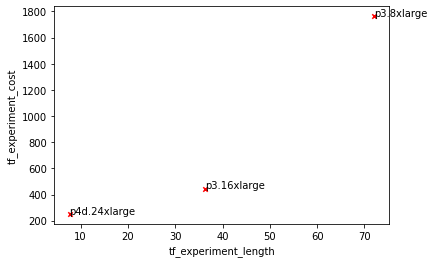

In [41]:
def plot_df(df):
    fig, ax = plt.subplots()
    df.plot(x='tf_experiment_length', y='tf_experiment_cost', kind='scatter', ax=ax, c='red', marker='x')
    for k, v in df.iterrows():
        ax.annotate(k, (v['tf_experiment_length'], v['tf_experiment_cost']))
    return fig

plot_df(df);

,tf_speedup,cnn_speedup,hourly_cost,tf_experiment_length,cnn_experiment_length,tf_experiment_cost,cnn_experiment_cost
name_gpu,,,,,,,
Lambda Cloud — 8x V100 16GB,1.403317,3.449175,4.4,51.307006,20.874559,225.750828,91.848060
4x A100 40GB PCIe,3.096360,3.351868,4.4,23.253109,21.480560,102.313681,94.514463
Lambda Cloud — 2x RTX A6000,1.000000,1.000000,1.6,72.000000,72.000000,115.200000,115.200000
Lambda Cloud — 4x RTX A6000,1.988182,1.899218,3.2,36.213997,37.910339,115.884789,121.313083


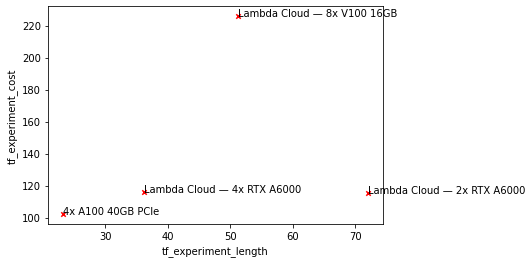

In [46]:
df = benchmark_df(
    df_all,
    pd.Series(
        [4.40, 4.40, 1.60, 3.20],
        ['4x A100 40GB PCIe', 'Lambda Cloud — 8x V100 16GB', 'Lambda Cloud — 2x RTX A6000', 'Lambda Cloud — 4x RTX A6000']
    ),
    'Lambda Cloud — 2x RTX A6000'
)
plot_df(df);
df